<a href="https://colab.research.google.com/github/beimnet777/coffee_disease_image_segmentation/blob/main/Segmentation_with_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
import cv2

In [ ]:
!pip install -U -q segmentation-models

In [ ]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
import os

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
unique_colors = [[0,0,0],[0,176,0],[0,0,255]]  
color_map = {tuple(color): i for i, color in enumerate(unique_colors)}

def process_mask_img(img,n_classes):
  labels = np.zeros((img.shape[0], img.shape[1]), dtype=int)
  for color, label in color_map.items():
      mask = np.all(img == color, axis=-1)
      labels[mask] = label
  
  train_mask = np.zeros((img.shape[0], img.shape[1], n_classes))
  for c in range(n_classes):
    train_mask[:, :, c] = (labels == c).astype(int)
  return train_mask

In [ ]:

def create_unet(width,height):
  WIDTH=width
  HEIGHT=height

  input=tf.keras.layers.Input((HEIGHT,WIDTH,1))
  x=tf.keras.layers.Lambda(lambda y: y/255)(input)
  DROP_OUT=0.2

  c1=tf.keras.layers.Conv2D(16,3,activation="relu",padding="same")(x)
  d1=tf.keras.layers.Dropout(DROP_OUT)(c1)
  c2=tf.keras.layers.Conv2D(16,3,activation="relu",padding="same")(d1)
  p1=tf.keras.layers.MaxPooling2D((2,2))(c2)

  c3=tf.keras.layers.Conv2D(32,3,activation="relu",padding="same")(p1)
  d2=tf.keras.layers.Dropout(DROP_OUT)(c3)
  c4=tf.keras.layers.Conv2D(32,3,activation="relu",padding="same")(d2)
  p2=tf.keras.layers.MaxPooling2D((2,2))(c4)

  c5=tf.keras.layers.Conv2D(64,3,activation="relu",padding="same")(p2)
  d3=tf.keras.layers.Dropout(DROP_OUT)(c5)
  c6=tf.keras.layers.Conv2D(64,3,activation="relu",padding="same")(d3)
  p3=tf.keras.layers.MaxPooling2D((2,2))(c6)

  c7=tf.keras.layers.Conv2D(128,3,activation="relu",padding="same")(p3)
  d4=tf.keras.layers.Dropout(DROP_OUT)(c7)
  c8=tf.keras.layers.Conv2D(128,3,activation="relu",padding="same")(d4)
  p4=tf.keras.layers.MaxPooling2D((2,2))(c8)

  c9=tf.keras.layers.Conv2D(256,3,activation="relu",padding="same")(p4)
  d5=tf.keras.layers.Dropout(DROP_OUT)(c9)
  c10=tf.keras.layers.Conv2D(256,3,activation="relu",padding="same")(d5)
  u5=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2))(c10)
  u5=tf.keras.layers.Concatenate()([u5,c8])



  c11=tf.keras.layers.Conv2D(128,3,activation="relu",padding="same")(u5)
  d6=tf.keras.layers.Dropout(DROP_OUT)(c11)
  c12=tf.keras.layers.Conv2D(128,3,activation="relu",padding="same")(d6)
  u6=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2))(c12)
  u6=tf.keras.layers.Concatenate()([u6,c6])

  c13=tf.keras.layers.Conv2D(64,3,activation="relu",padding="same")(u6)
  d7=tf.keras.layers.Dropout(DROP_OUT)(c13)
  c14=tf.keras.layers.Conv2D(64,3,activation="relu",padding="same")(d7)
  u7=tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2))(c14)
  u7=tf.keras.layers.Concatenate()([u7,c4])

  c15=tf.keras.layers.Conv2D(32,3,activation="relu",padding="same")(u7)
  d8=tf.keras.layers.Dropout(DROP_OUT)(c15)
  c16=tf.keras.layers.Conv2D(32,3,activation="relu",padding="same")(d8)
  u8=tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2))(c16)
  u8=tf.keras.layers.Concatenate()([u8,c2])

  c17=tf.keras.layers.Conv2D(16,3,activation="relu",padding="same")(u8)
  d9=tf.keras.layers.Dropout(DROP_OUT)(c17)
  c18=tf.keras.layers.Conv2D(16,3,activation="relu",padding="same")(d9)


  outputs=tf.keras.layers.Conv1D(1,1,activation="sigmoid")(c18)

  model=tf.keras.Model(inputs=[input],outputs=[outputs])
  model.summary()
  return model

In [ ]:
def change_mask_to_bw(path):
  print(path)
  img = cv2.imread(path)
  gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  (thresh, im_bw) = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  return im_bw

In [ ]:
def prepare_dataset(width,height,X_path,Y_path=None):
  
  for (root ,dirs,files) in os.walk(X_path):
    X=np.zeros((len(files),height,width,1),dtype=np.uint8)
    y=np.zeros((len(files),height,width,1),dtype=np.uint8)
    index=0
    for file in files:
      image_num=file.split(".")[0]
      image_y_name=image_num+"_mask.png"
      path_x=os.path.join(X_path,file)
      if Y_path:
        path_y=os.path.join(Y_path,image_y_name)
        img_y=change_mask_to_bw(path_y)
        img_y=cv2.resize(img_y, (width, height))
        img_y=np.expand_dims(img_y,axis=-1)
        y[index]=img_y.astype(np.float32)

      img_x=cv2.imread(path_x)
      img_x=cv2.resize(img_x, (width, height))
      img_x = cv2.cvtColor(img_x, cv2.COLOR_BGR2GRAY)
      img_x = cv2.equalizeHist(img_x)

      norm_img = np.zeros((img_x.shape[0], img_x.shape[1]))
      norm_img = cv2.normalize(img_x, norm_img, 0, 255, cv2.NORM_MINMAX)
      norm_img=np.expand_dims(norm_img,axis=-1)
      X[index]=norm_img.astype(np.float32)
        
      index+=1
  
  return X,y

In [ ]:
train=prepare_dataset(512,256,"/content/drive/MyDrive/images/train","/content/drive/MyDrive/annotations/train")
test=prepare_dataset(512,256,"/content/drive/MyDrive/images/test","/content/drive/MyDrive/annotations/test")
val=prepare_dataset(512,256,"/content/drive/MyDrive/images/val","/content/drive/MyDrive/annotations/val")
     

/content/drive/MyDrive/annotations/train/1151_mask.png
/content/drive/MyDrive/annotations/train/1183_mask.png
/content/drive/MyDrive/annotations/train/1554_mask.png
/content/drive/MyDrive/annotations/train/1589_mask.png
/content/drive/MyDrive/annotations/train/1710_mask.png
/content/drive/MyDrive/annotations/train/1695_mask.png
/content/drive/MyDrive/annotations/train/1487_mask.png
/content/drive/MyDrive/annotations/train/1693_mask.png
/content/drive/MyDrive/annotations/train/1531_mask.png
/content/drive/MyDrive/annotations/train/1682_mask.png
/content/drive/MyDrive/annotations/train/1088_mask.png
/content/drive/MyDrive/annotations/train/1699_mask.png
/content/drive/MyDrive/annotations/train/149_mask.png
/content/drive/MyDrive/annotations/train/1638_mask.png
/content/drive/MyDrive/annotations/train/1579_mask.png
/content/drive/MyDrive/annotations/train/1664_mask.png
/content/drive/MyDrive/annotations/train/1737_mask.png
/content/drive/MyDrive/annotations/train/1425_mask.png
/content/dr

In [ ]:
print(len(train[0]),len(test[0]),len(val[0]))

400 50 50


In [ ]:
model=create_unet(512,256)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_6 (Lambda)              (None, 256, 512, 1)  0           ['input_7[0][0]']                
                                                                                                  
 conv2d_108 (Conv2D)            (None, 256, 512, 16  160         ['lambda_6[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
model.fit(train[0],train[1]//255,epochs=20,batch_size=16,validation_data=(test[0],test[1]//255))

Epoch 1/20
25/25 [==============================] - 15s 359ms/step - loss: 0.5137 - accuracy: 0.6370 - val_loss: 0.3506 - val_accuracy: 0.6580
Epoch 2/20
25/25 [==============================] - 9s 347ms/step - loss: 0.1799 - accuracy: 0.9115 - val_loss: 0.0939 - val_accuracy: 0.9647
Epoch 3/20
25/25 [==============================] - 9s 344ms/step - loss: 0.0526 - accuracy: 0.9824 - val_loss: 0.0573 - val_accuracy: 0.9803
Epoch 4/20
25/25 [==============================] - 9s 351ms/step - loss: 0.0359 - accuracy: 0.9872 - val_loss: 0.0478 - val_accuracy: 0.9844
Epoch 5/20
25/25 [==============================] - 9s 347ms/step - loss: 0.0287 - accuracy: 0.9893 - val_loss: 0.0566 - val_accuracy: 0.9849
Epoch 6/20
25/25 [==============================] - 9s 353ms/step - loss: 0.0290 - accuracy: 0.9893 - val_loss: 0.0415 - val_accuracy: 0.9848
Epoch 7/20
25/25 [==============================] - 9s 350ms/step - loss: 0.0251 - accuracy: 0.9907 - val_loss: 0.0359 - val_accuracy: 0.9883
Epoch

In [ ]:
val[0].shape

In [ ]:
prediction=model.predict(val[0])

2/2 [==============================] - 5s 2s/step


In [ ]:
for index,img in enumerate(prediction):
  img=(img>=0.5)
  img = img.astype(int)
  img*=255
  cv2_imshow(val[0][index])
  cv2_imshow(img)

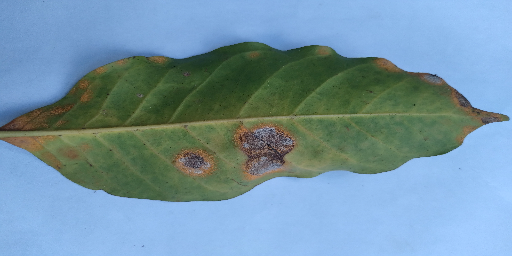

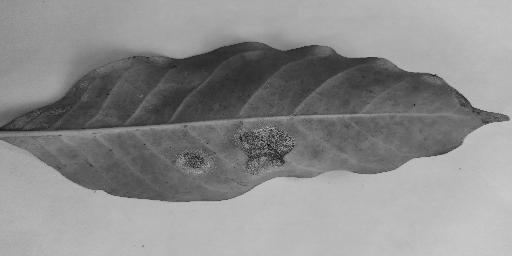

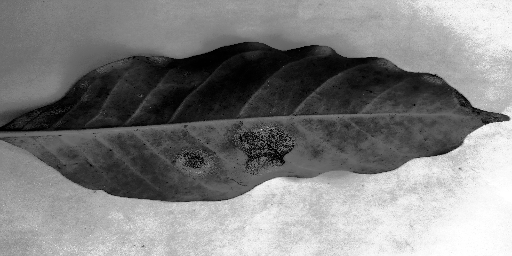

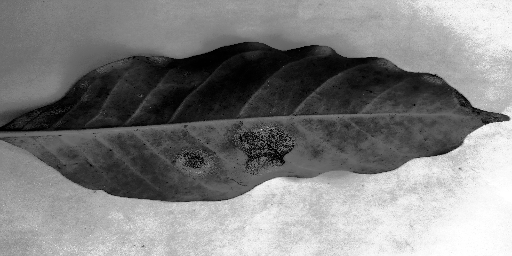

1/1 [==============================] - 0s 33ms/step


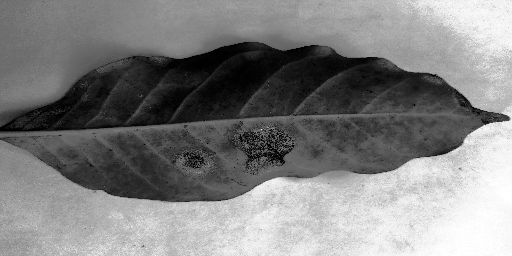

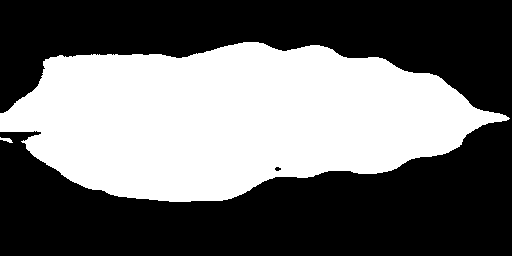

In [ ]:
img_x=cv2.imread("/content/drive/MyDrive/coffee_test_annotations/coffee_test_annotations/090104.jpg")
img_x = cv2.rotate(img_x, cv2.ROTATE_90_CLOCKWISE)
img_x=cv2.resize(img_x, (512, 256))
cv2_imshow(img_x)




img_x = cv2.cvtColor(img_x, cv2.COLOR_BGR2GRAY)


cv2_imshow(img_x)
img_x = cv2.equalizeHist(img_x)
cv2_imshow(img_x)

norm_img = np.zeros((img_x.shape[0], img_x.shape[1]))
norm_img = cv2.normalize(img_x, norm_img, 0, 255, cv2.NORM_MINMAX)
cv2_imshow(norm_img)



img_x=np.expand_dims(norm_img,axis=-1)
img_x=np.expand_dims(img_x,axis=0)
prediction=model.predict(img_x)
for index,img in enumerate(prediction):
  img=(img>=0.5)
  img = img.astype(int)
  img*=255
  cv2_imshow(img_x[0])
  cv2_imshow(img)